## DNR Smoke Management Burn Approval Rate and Data Clean Up

### Only applies to data from 2014 - 2019 from the burn portal 

Another useful performance metric within the wildfire program is the % of silvicultural burns we approve. We work to balance healthy air quality for the public while also maximizing burns which reduce the risk of hazardous wildfires. 

Import helpful libraries

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

Merge all of the .csvs into one

In [2]:
df = pd.concat(map(pd.read_csv, glob('*.csv')), sort=True)
df.head(2)

,Agent,Application ID,Burn Decision,Burn Priority,Burn Request ID,Decision Date,Est. Permit Tonnage,Forest Health Exempt,Harvest Acres,Ignition Date,...,Request Year,Smoke Dispersed,Status,Total Proposed Burn,Unit Name,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1
0,Ryley Gray,10100,NaN,2.0,13461,NaN,173 tons,NaN,116 acres,"Dec 31, 2019 08:00:00",...,NaN,NaN,"ApprovedDec 31, 2019",173 tons,5381,NaN,NaN,NaN,NaN,NaN
1,Ryley Gray,10099,NaN,1.0,13462,NaN,179 tons,NaN,64 acres,"Dec 31, 2019 08:00:00",...,NaN,NaN,"ApprovedDec 31, 2019",179 tons,6365D,NaN,NaN,NaN,NaN,NaN


It is immediately clear this data is in bad shape. We need to drop all of extra info in numeric columns and split lat/lon.

In [3]:
def string_purger(x):
    if pd.isna(x) == False:  # there are weird 'nan' floats apparently...
        y = str(x).split(' ')[0]
        return float(y.replace(',', ''))

def lat(x):
    if pd.isna(x) == False:
        return x.split(',')[0]
    
def lon(x):
    if pd.isna(x) == False:
        return x.split(',')[1]
       
df['Ignition Period'] = df['Ignition Period'].apply(string_purger)
df['Est. Permit Tonnage'] = df['Est. Permit Tonnage'].apply(string_purger)
df['Total Proposed Burn'] = df['Total Proposed Burn'].apply(string_purger)
df['Harvest Acres'] = df['Harvest Acres'].apply(string_purger)
df['Proposed Burn Area'] = df['Proposed Burn Area'].apply(string_purger)
df['Lat'] = df['Lat, Long'].apply(lat)
df['Lon'] = df['Lat, Long'].apply(lon)

# Drop the old lat/lon column and purge NaNs to None
df = df.drop(columns = ['Lat, Long'])
df = df.replace({np.nan: None})
df.head(2)

,Agent,Application ID,Burn Decision,Burn Priority,Burn Request ID,Decision Date,Est. Permit Tonnage,Forest Health Exempt,Harvest Acres,Ignition Date,...,Request Year,Smoke Dispersed,Status,Total Proposed Burn,Unit Name,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1
0,Ryley Gray,10100,None,2,13461,None,173,None,116,"Dec 31, 2019 08:00:00",...,None,None,"ApprovedDec 31, 2019",173,5381,None,None,None,None,None
1,Ryley Gray,10099,None,1,13462,None,179,None,64,"Dec 31, 2019 08:00:00",...,None,None,"ApprovedDec 31, 2019",179,6365D,None,None,None,None,None


There are three columns (Request Date, Status, Ignition Date) with some type of date in them, need to fix these as well.

In [4]:
df['Ignition Date'] = pd.to_datetime(df['Ignition Date'])
df['Request Date'] = pd.to_datetime(df['Request Date'])
df['Request Year'] = df['Request Date'].dt.year
df['Request Month'] = df['Request Date'].dt.month

# Status is silly, why would the system concatenate the date and approval status? 
# Am going to make two columns for this 

def approval_state(x):
    if x != None:
        return x.split('ed')[0] + 'ed'
    else: 
        return None
    
def approval_date(x):
    if x != None:
        return x.split('ed')[1]
    else:
        return None
    
df['Burn Decision'] = df['Status'].apply(approval_state)
df['Decision Date'] = df['Status'].apply(approval_date)
df['Decision Date'] = pd.to_datetime(df['Decision Date'])
df = df.drop(columns = ['Status'])

One more useful thing might be to get the region the smoke data is for. It looks like anything with `40` is a federal burn and all of the regions have a two character prefix (i.e. `PC`, `NE`)

In [5]:
def region_getter(x):
    y = x[:2]
    # Federal, Fish & Wildlife, and JBLM
    if y in ['40', 'FW', 'JB']:
        return 'FED'
    # Northeast bad entry
    elif y in ['NO', '20']:
        return 'NE'
    # Southeast bad entry
    elif y in ['SO', 'WA']:
        return 'SE'
    else:
        return y
    
df['Region'] = df['Permit Number'].apply(region_getter)

Plot the frequency of burn permits by region/fed

In [115]:
#df.groupby(['Region'])['Region'].hist()

Plot frequency of burn requests by year and then by month


Request Year
2014    AxesSubplot(0.125,0.125;0.775x0.755)
2015    AxesSubplot(0.125,0.125;0.775x0.755)
2016    AxesSubplot(0.125,0.125;0.775x0.755)
2017    AxesSubplot(0.125,0.125;0.775x0.755)
2018    AxesSubplot(0.125,0.125;0.775x0.755)
2019    AxesSubplot(0.125,0.125;0.775x0.755)
2020    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Request Year, dtype: object

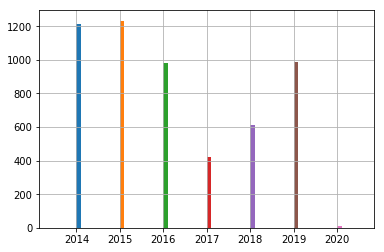

In [10]:
df.groupby(['Request Year'])['Request Year'].hist()

Request Month
1     AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
5     AxesSubplot(0.125,0.125;0.775x0.755)
6     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
8     AxesSubplot(0.125,0.125;0.775x0.755)
9     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Request Month, dtype: object

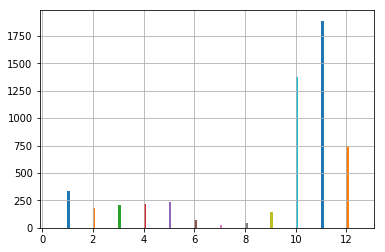

In [11]:
df.groupby(['Request Month'])['Request Month'].hist()

What is the approval rate?

In [114]:
#df.groupby(['Burn Decision'])['Burn Decision'].hist()

In [13]:
total = len(df['Burn Decision'])
approvals = len(df[(df['Burn Decision'] =='Approved') | (df['Burn Decision'] == '[Division] Approved')])

approval_rate = approvals/total
"The burn approval rate is {}".format(round(approval_rate, 2))

'The burn approval rate is 0.78'

Export to csv

In [14]:
df.to_csv('smokedata_2014_2019_clean_test.csv')

What is the average request tonnage for those approved? 

In [15]:
approvals = df[(df['Burn Decision'] =='Approved') | (df['Burn Decision'] == '[Division] Approved')]
approvals['Total Proposed Burn'].mean()

139.1609033168666

What is the average burn period? 

In [16]:
df['Ignition Period'].mean()

86.7356279751007

How many burn requests have we had since the start of 2014?

In [20]:
print('Number of Burn Requests since the start of 2014: ', len(df['Burn Decision']))

Number of Burn Requests since the start of 2014:  5462


Breakdown of Burn Requests by Year

In [55]:
df2014 = df[df['Request Year'] == 2014]
df2015 = df[df['Request Year'] == 2015]
df2016 = df[df['Request Year'] == 2016]
df2017 = df[df['Request Year'] == 2017]
df2018 = df[df['Request Year'] == 2018]
df2019 = df[df['Request Year'] == 2019]
df2020 = df[df['Request Year'] == 2020]

In [57]:
df2014_approved = df2014[(df2014['Burn Decision'] == 'Approved') | (df2014['Burn Decision'] == '[Division] Approved')]
df2015_approved = df2015[(df2015['Burn Decision'] == 'Approved') | (df2015['Burn Decision'] == '[Division] Approved')]
df2016_approved = df2016[(df2016['Burn Decision'] == 'Approved') | (df2016['Burn Decision'] == '[Division] Approved')]
df2017_approved = df2017[(df2017['Burn Decision'] == 'Approved') | (df2017['Burn Decision'] == '[Division] Approved')]
df2018_approved = df2018[(df2018['Burn Decision'] == 'Approved') | (df2018['Burn Decision'] == '[Division] Approved')]
df2019_approved = df2019[(df2019['Burn Decision'] == 'Approved') | (df2019['Burn Decision'] == '[Division] Approved')]
df2020_approved = df2020[(df2020['Burn Decision'] == 'Approved') | (df2020['Burn Decision'] == '[Division] Approved')]

In [58]:
df2014_denied = df2014[df2014['Burn Decision'] == 'Denied']
df2015_denied = df2015[df2015['Burn Decision'] == 'Denied']
df2016_denied = df2016[df2016['Burn Decision'] == 'Denied']
df2017_denied = df2017[df2017['Burn Decision'] == 'Denied']
df2018_denied = df2018[df2018['Burn Decision'] == 'Denied']
df2019_denied = df2019[df2019['Burn Decision'] == 'Denied']
df2020_denied = df2020[df2020['Burn Decision'] == 'Denied']

In [59]:
df2014_other = df2014[pd.isna(df2014['Burn Decision']) == True]
df2015_other = df2015[pd.isna(df2015['Burn Decision']) == True]
df2016_other = df2016[pd.isna(df2016['Burn Decision']) == True]
df2017_other = df2017[pd.isna(df2017['Burn Decision']) == True]
df2018_other = df2018[pd.isna(df2018['Burn Decision']) == True]
df2019_other = df2019[pd.isna(df2019['Burn Decision']) == True]
df2020_other = df2020[pd.isna(df2020['Burn Decision']) == True]

Show the total yearly burn requests divided up by the burn decision. Did the burn requests decrease in 2018 and 2019?

In [60]:
print('2014 Burn Requests: ', 'Approved: ', len(df2014_approved), ' Denied: ', len(df2014_denied), ' Unspecified: ', len(df2014_other), ' Total: ', len(df2014))
print('2015 Burn Requests: ', 'Approved: ', len(df2015_approved), ' Denied: ', len(df2015_denied), ' Unspecified: ', len(df2015_other), ' Total: ', len(df2015))
print('2016 Burn Requests: ', 'Approved: ', len(df2016_approved), ' Denied: ', len(df2016_denied), ' Unspecified: ', len(df2016_other), ' Total: ', len(df2016))
print('2017 Burn Requests: ', 'Approved: ', len(df2017_approved), ' Denied: ', len(df2017_denied), ' Unspecified: ', len(df2017_other), ' Total: ', len(df2017))
print('2018 Burn Requests: ', 'Approved: ', len(df2018_approved), ' Denied: ', len(df2018_denied), ' Unspecified: ', len(df2018_other), ' Total: ', len(df2018))
print('2019 Burn Requests: ', 'Approved: ', len(df2019_approved), ' Denied: ', len(df2019_denied), ' Unspecified: ', len(df2019_other), ' Total: ', len(df2019))
print('2020 Burn Requests: ', 'Approved: ', len(df2020_approved), ' Denied: ', len(df2020_denied), ' Unspecified: ', len(df2020_other), ' Total: ', len(df2020))



2014 Burn Requests:  Approved:  951  Denied:  105  Unspecified:  159  Total:  1215
2015 Burn Requests:  Approved:  864  Denied:  53  Unspecified:  316  Total:  1233
2016 Burn Requests:  Approved:  733  Denied:  74  Unspecified:  173  Total:  980
2017 Burn Requests:  Approved:  327  Denied:  25  Unspecified:  71  Total:  423
2018 Burn Requests:  Approved:  533  Denied:  5  Unspecified:  72  Total:  610
2019 Burn Requests:  Approved:  832  Denied:  63  Unspecified:  95  Total:  990
2020 Burn Requests:  Approved:  11  Denied:  0  Unspecified:  0  Total:  11


2018 & 2019 were lower than previous years, but not as low as 2017.

In 2017, is there any indication the Bureau of Indian Affairs (BIA) burns were reported in the dataset?

Export the 2017 data to a csv

In [61]:
df2017.to_csv('smokedata_2017_clean.csv')

Search for BIA terms in various columns of the dataset

In [109]:
word_search = []
with open("smokedata_2017_clean.csv") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        word_search.append(row)
        
name = input("Enter a search term: ")

#column 13 is the Landowner of the Burn Request
#column 1 is the Agent of the Burn Request
#column 26 is the Unit Name
col = [x[13] for x in word_search]

if name in col:
    for x in range(0,len(word_search)):
        if name == word_search[x][13]:
            print(word_search[x])
else:
    print("Word is not found")

Enter a search term: Indian
Word is not found


Search for BIA terms in the dataset for all 5 years.

In [111]:
word_search = []
with open("smokedata_2014_2019_clean.csv") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        word_search.append(row)
        
name = input("Enter a search term: ")

#column 11 is the Landowner of the Burn Request
#column 1 is the Agent
#column 19 is the Unit Name
col = [x[11] for x in word_search]

if name in col:
    for x in range(0,len(word_search)):
        if name == word_search[x][11]:
            print(word_search[x])
else:
    print("Word is not found")

Enter a search term: Tribe
Word is not found


After searching terms such as Bureau of Indian Affairs, BIA, Tribe, etc., no rows were found with terms such as these in the 2017 data.